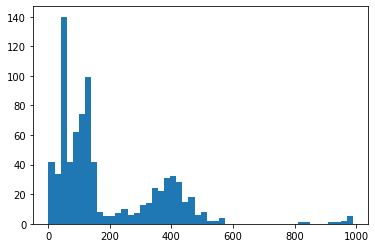

In [144]:
from urllib.parse import urlparse, parse_qs
import randomcolor
import datetime
import matplotlib.pyplot as plt
rcolor = randomcolor.RandomColor()

path = './may-28.txt'
data = []
with open(path, 'r', encoding='utf8') as file:
    l = 0
    for line in file:
        data.append(line)
        if l > 2000:
            break
        l += 1

class Page:
    def __init__(self, info):
        if ' ' in info:
            parts = info.split(' | ')
        else:
            parts = info, ''
        self.url, self.title = parts[0], ''.join(parts[1:])
        self.parse = urlparse(self.url)
        self.params = parse_qs(self.parse.query)
        self.tags = []
        self.len = len(self.url)
        
class Tag:
    def __init__(self, name=''):
        self.name = name
        self.color = rcolor.generate()
        self.created = str(datetime.datetime.now())
        
class Collection:
    def __init__(self, urls=None):
        self.urls = []
        if urls:
            self.add(urls)
        
    def add(self, urls):
        if type(urls) is str:
            urls = [urls]
        if type(urls) is list:
            for url in urls:
                if type(url) is str:
                    self.urls.append(Page(url))
                elif type(url) is Page:
                    self.urls.append(url)
    
    def find(self, attr, value=None):
        if not callable(attr):
            attr = lambda x: getattr(x, attr) == value
        return Collection(list(filter(attr, self.urls)))
    
    def tag(self, tags):
        if type(tags) is str:
            tags = Tag(tags)
        if type(tags) is Tag:
            tags = [tags]
        for u in self.urls:
            u.tags.extend(tags)
        return self
    
    def visualize(self, property='len'):
        summary = [getattr(u, property) for u in self.urls]
        plt.hist(summary, bins=50)
    
    def __getitem__(self, i):
        return self.urls[i]
    
c = Collection()
c.add(data)
# print(c.urls[100].parse)
# c.find(lambda x: len(x.url)>1000)[5]
w = c.find(lambda x: 'Wikipedia' in x.title).tag('Wikipedia')
# w[0]
# t.created
# c.tag(t)[0].tags[0].name
# c[100].params
c.find(lambda x: x.len < 1000).visualize()

In [35]:
data[1][5]

'e'

In [141]:
len(data)

1002